## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [1]:
from skimage.feature import peak_local_max
from matplotlib.patches import Patch
from typing import List, Tuple, Any
from dataclasses import dataclass
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm
import numpy as np
import cv2
import time

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

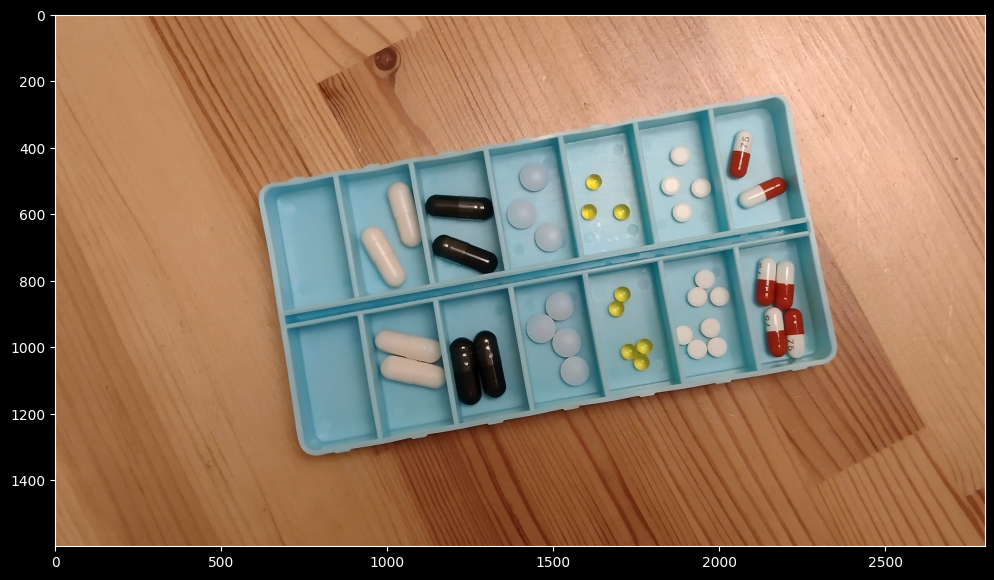

In [2]:
calib = cv2.imread('dane5/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [ ]:
# class PillType(Enum):
#     PROBIO = 1    # duże białe kapsułki
#     CARBON = 2    # duże czarne kapsułki
#     KETO = 3      # niebieskie tabletki
#     ESPU = 4      # małe żółte kapsułki
#     BIOX = 5      # małe białe tabletki
#     LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [4]:
def rhotheta2xy(line):
  # konwersja parametrów prostej w układzie rho-theta do odcinka w układzie kartezjańskim
  # wynik można użyć jako argumenty funkcji cv2.line
  rho, theta = line[0]
  a = np.cos(theta)
  b = np.sin(theta)
  x0 = a*rho
  y0 = b*rho
  x1 = int(x0 + 5000*(-b))
  y1 = int(y0 + 5000*(a))
  x2 = int(x0 - 5000*(-b))
  y2 = int(y0 - 5000*(a))
  return x1, y1, x2, y2

In [5]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [ ]:
# def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
#     # TU BĘDZIE TWOJA IMPLEMENTACJA DETEKTORA
#     raise NotImplementedError

In [ ]:
# COLORMAP = {
#     # RGB colorspace
#     PillType.PROBIO: (255, 255, 255),
#     PillType.CARBON: (0, 0, 0),
#     PillType.KETO: (0, 0, 255),
#     PillType.ESPU: (255, 255, 0),
#     PillType.BIOX: (255, 0, 255),
#     PillType.LINE: (255, 0, 0),
# }

# def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
#     # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
#     image = image.copy()
#     # ...
#     plt.imshow(image)

In [8]:
# found = detect_objects(calib)
# display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

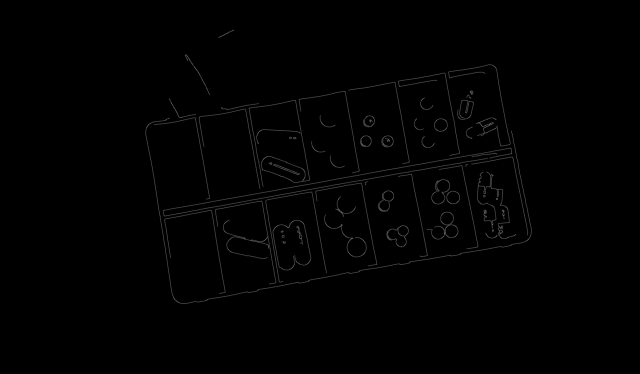

In [9]:
filtered_calib = cv2.GaussianBlur(calib, (11, 11), 0)

calib_edges = cv2.Canny(filtered_calib, 50, 150)

plt.figure(figsize=(8,8))
plt.imshow(calib_edges, cmap='gray')
plt.axis('off')
plt.show()

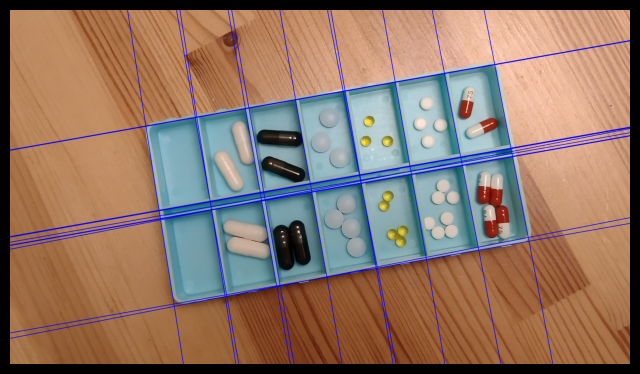

In [10]:
rho_pillbox = 1
theta_pillbox = np.pi / 180
threshold_pillbox = 200

lines_pillbox = cv2.HoughLines(calib_edges, rho_pillbox, theta_pillbox, threshold_pillbox)

pillbox_with_lines = calib.copy()

for line in lines_pillbox:
  x1, y1, x2, y2 = rhotheta2xy(line)
  cv2.line(pillbox_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(8,8))
plt.imshow(pillbox_with_lines[..., ::-1])
plt.axis('off')
plt.show()

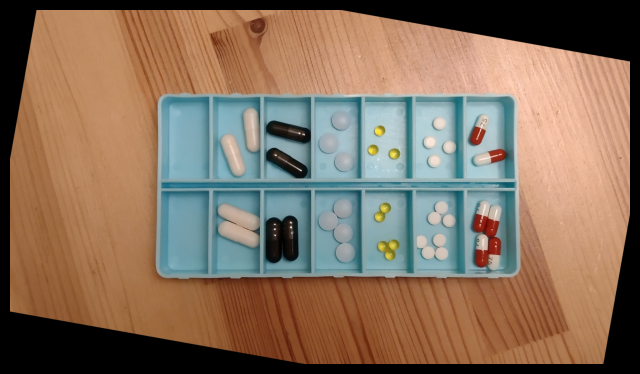

In [ ]:
def get_rotation_angle(lines):
  angles = []
  for line in lines:
    rho, theta = line[0]
    # Convert theta to degrees
    angle = theta * 180 / np.pi
    # We're interested in horizontal lines (angles near 0 or 180)
    if angle < 45 or angle > 135:
      angles.append(angle)

  # Get the average angle
  mean_angle = np.mean(angles)
  if mean_angle > 90:
    return mean_angle - 180
  
  return mean_angle

# Get the rotation angle
angle = get_rotation_angle(lines_pillbox)

# Rotate the image
height, width = calib.shape[:2]
center = (width/2, height/2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(calib, rotation_matrix, (width, height))

plt.figure(figsize=(8, 8))
plt.imshow(rotated_image[..., ::-1])
plt.axis('off')
plt.show()

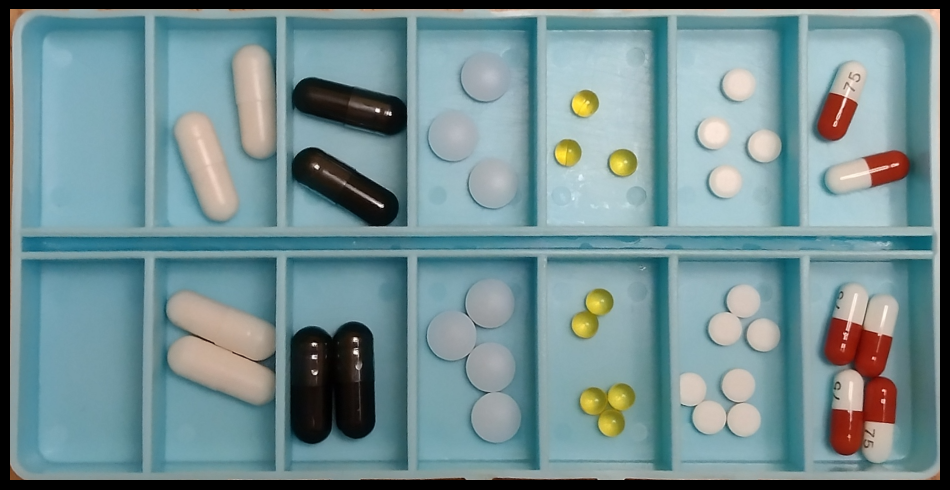

In [12]:
# After rotation, let's improve the pillbox detection and cropping
rotated_gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)

# Let's try using color to detect the blue box instead
hsv = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2HSV)
# Blue color range in HSV
lower_blue = np.array([90,50,50])
upper_blue = np.array([130,255,255])
blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Clean up the mask
kernel = np.ones((5,5), np.uint8)
blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)

# Find contours of the pillbox
contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pillbox_contour = max(contours, key=cv2.contourArea)

# Get a tighter bounding rect
x, y, w, h = cv2.boundingRect(pillbox_contour)

# Add a small padding to avoid cutting pills
padding = 10
x = max(0, x - padding)
y = max(0, y - padding)
w = min(rotated_image.shape[1] - x, w + 2*padding)
h = min(rotated_image.shape[0] - y, h + 2*padding)

# Crop the pillbox
calib_cropped = rotated_image[y:y+h, x:x+w]

# Debug visualization
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(calib_cropped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

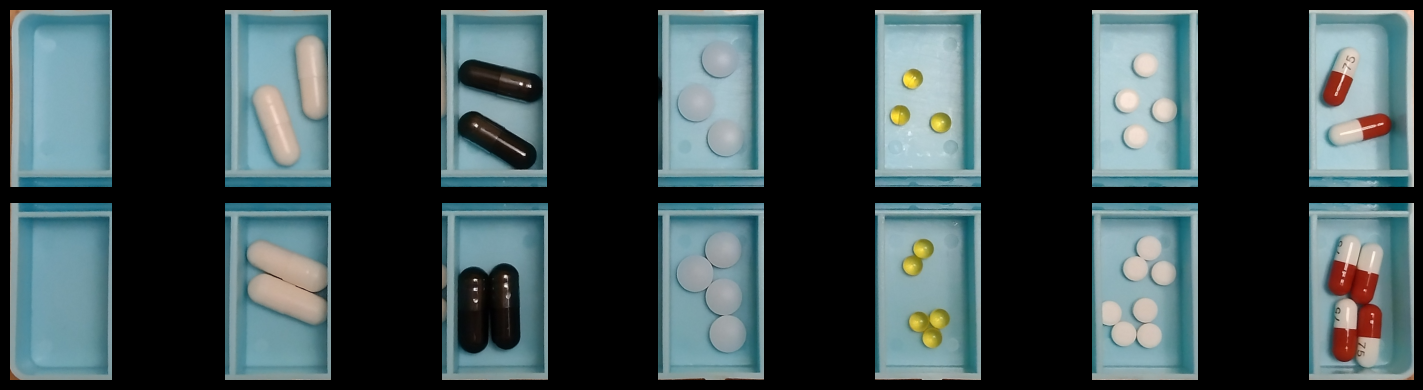

In [13]:
def get_cells_of_pillbox(image, padding=10):
    if len(image.shape) == 2:
        h, w = image.shape
    # Otherwise, assume it's a 3-channel color image
    else:
        h, w, _ = image.shape

    # Divide the image into 2 rows and 7 columns
    cell_height = h // 2
    cell_width = w // 7
    
    cells = []
    for row in range(2):
        for col in range(7):
            x1 = max(0, col * cell_width - padding)
            y1 = max(0, row * cell_height - padding)
            x2 = min(w, (col + 1) * cell_width + padding)
            y2 = min(h, (row + 1) * cell_height + padding)
            cell = image[y1:y2, x1:x2]
            cells.append(cell)
    
    return cells

cells = get_cells_of_pillbox(calib_cropped)

# Display the cells in a 2x7 subplot
fig, axes = plt.subplots(2, 7, figsize=(16, 4))
for i, cell in enumerate(cells):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(cv2.cvtColor(cell, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [14]:
def display_image_and_histogram_hsv(image,  figsize=(12,4)):
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(image_hsv)

  fig, axs = plt.subplots(2, 3, figsize=figsize)
  axs[0, 0].imshow(h, cmap='gray')
  axs[0, 0].set_title('Hue')
  axs[0, 0].axis('off')
  axs[0, 1].imshow(s, cmap='gray')
  axs[0, 1].set_title('Saturation')
  axs[0, 1].axis('off')
  axs[0, 2].imshow(v, cmap='gray')
  axs[0, 2].set_title('Value')
  axs[0, 2].axis('off')
  axs[1, 0].hist(h.ravel(), bins=256, color='gray')
  axs[1, 1].hist(s.ravel(), bins=256, color='gray')
  axs[1, 2].hist(v.ravel(), bins=256, color='gray')
  plt.tight_layout()
  plt.show()

  return image_hsv

In [15]:
def display_image_and_histogram_lab(image,  figsize=(12,4)):
  image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  h, s, v = cv2.split(image_lab)

  fig, axs = plt.subplots(2, 3, figsize=figsize)
  axs[0, 0].imshow(h, cmap='gray')
  axs[0, 0].set_title('L')
  axs[0, 0].axis('off')
  axs[0, 1].imshow(s, cmap='gray')
  axs[0, 1].set_title('a')
  axs[0, 1].axis('off')
  axs[0, 2].imshow(v, cmap='gray')
  axs[0, 2].set_title('b')
  axs[0, 2].axis('off')
  axs[1, 0].hist(h.ravel(), bins=256, color='gray')
  axs[1, 1].hist(s.ravel(), bins=256, color='gray')
  axs[1, 2].hist(v.ravel(), bins=256, color='gray')
  plt.tight_layout()
  plt.show()

  return image_lab

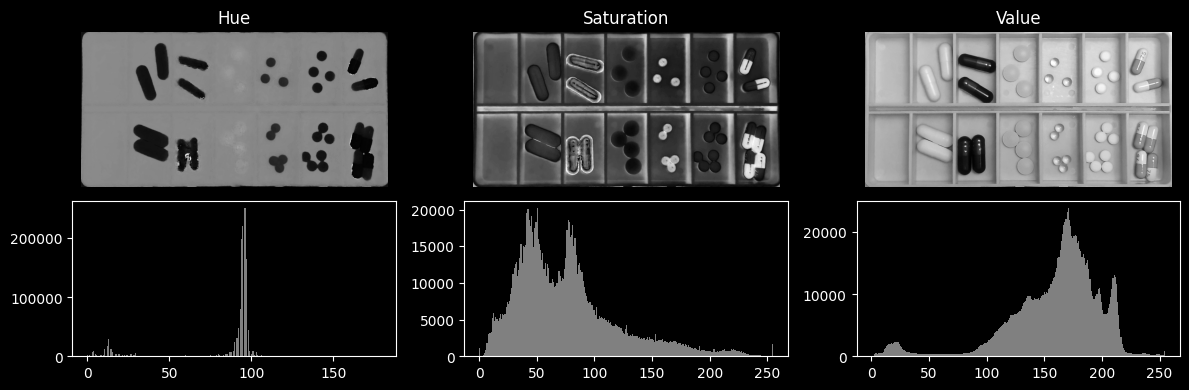

In [16]:
hsv = display_image_and_histogram_hsv(calib_cropped)

In [17]:
h, s, v = cv2.split(hsv)

h_blurred = cv2.GaussianBlur(h, (5,5), 0)

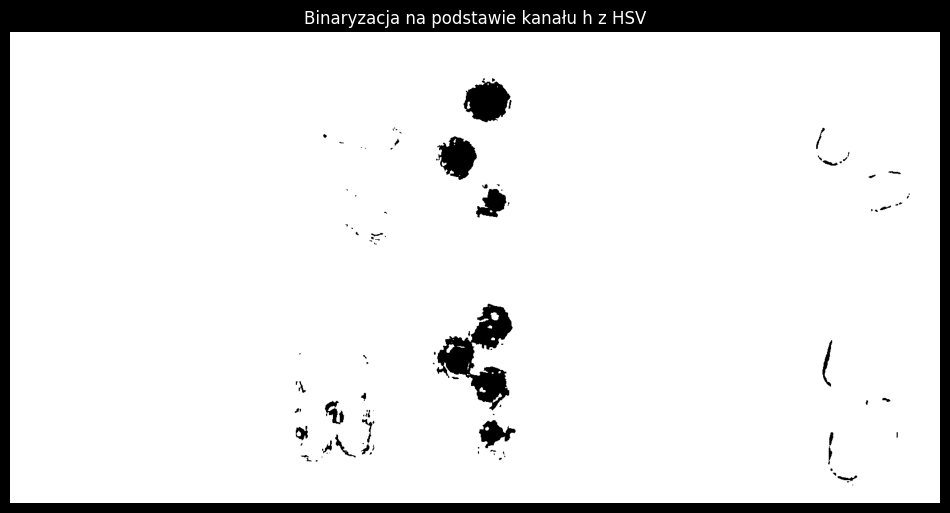

In [18]:
_, h_binary = cv2.threshold(h_blurred, 100, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(12,8))
plt.imshow(h_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału h z HSV')
plt.axis('off')
plt.show()

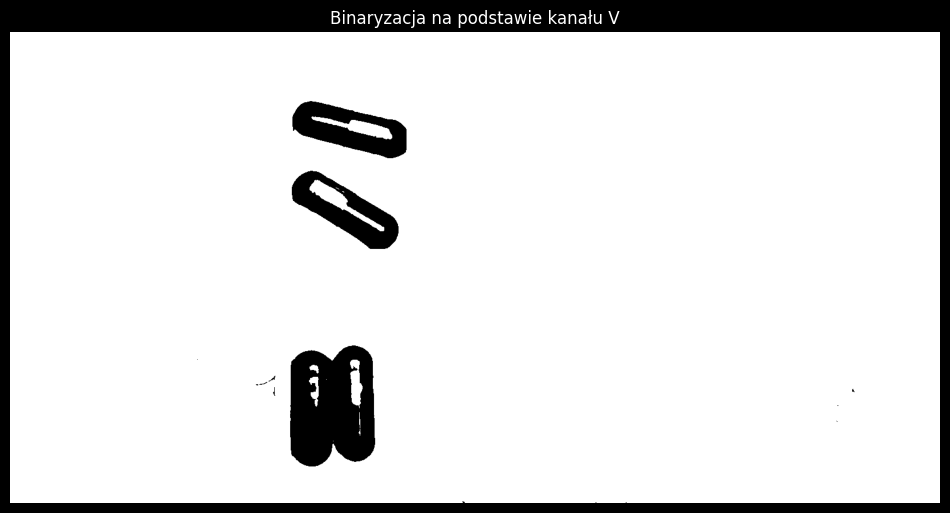

In [19]:
v_blurred = cv2.GaussianBlur(v, (5,5), 0)
threshold = 50
_, v_binary = cv2.threshold(v_blurred, threshold, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,8))
plt.imshow(v_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału V')
plt.axis('off')
plt.show()

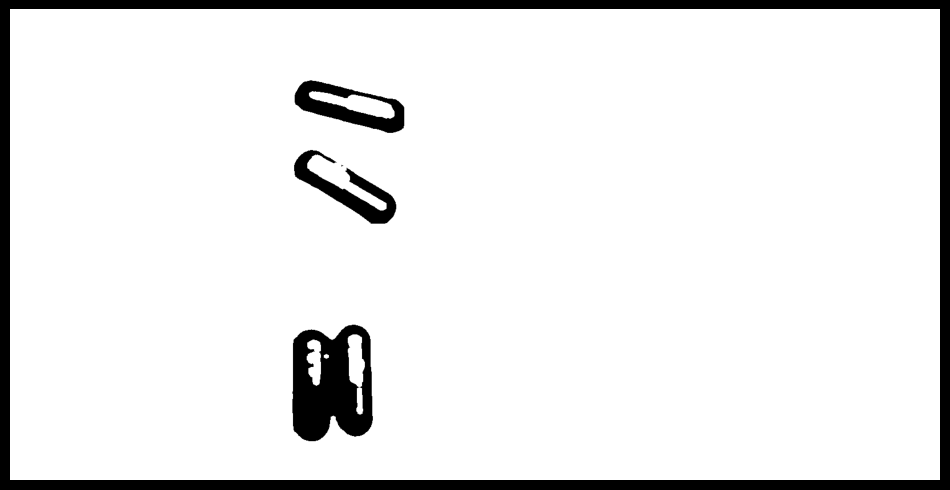

In [20]:
# distilation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)

plt.figure(figsize=(12,8))
plt.imshow(v_binary_eroded, cmap='gray')
plt.axis('off')
plt.show()


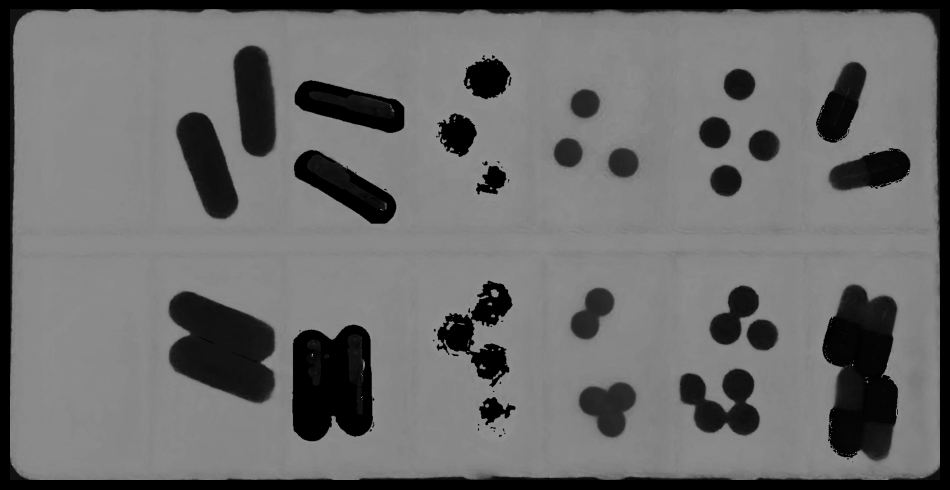

In [ ]:
# add black parts of h_binary to h_blurred
h[h_binary == 0] = 0
h[v_binary_eroded == 0] = 0

plt.figure(figsize=(12,8))
plt.imshow(h, cmap='gray')
plt.axis('off')
plt.show()

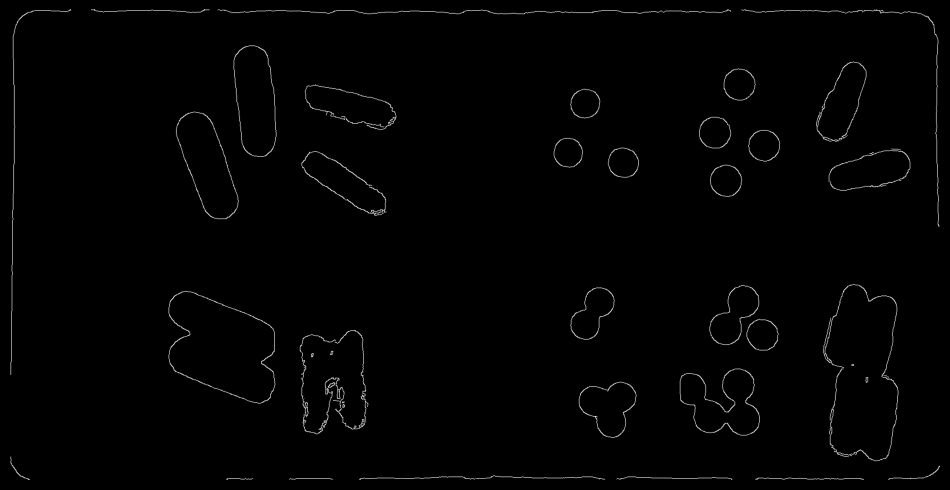

In [22]:
canny = cv2.Canny(h_blurred, 50, 150)

plt.figure(figsize=(12,8))
plt.imshow(canny, cmap='gray')
plt.axis('off')
plt.show()

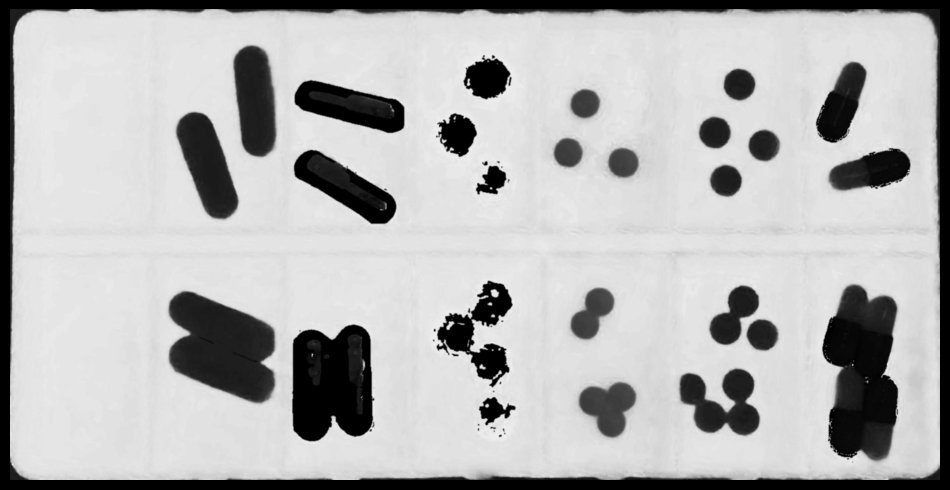

In [23]:
h_blurred = cv2.GaussianBlur(h, (3,3), 0)

plt.figure(figsize=(12,8))
plt.imshow(h_blurred, cmap='gray')
plt.axis('off')
plt.show()

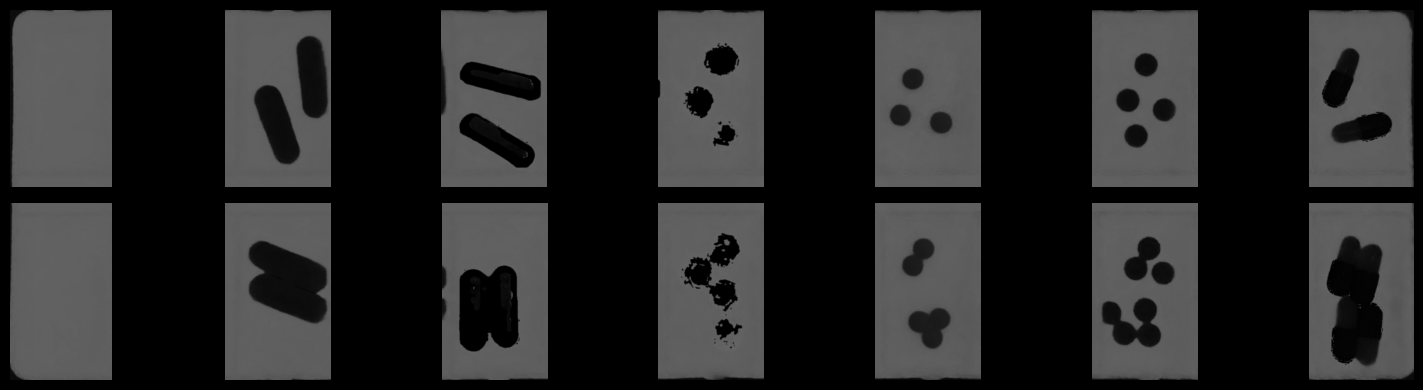

In [24]:
cells = get_cells_of_pillbox(h_blurred)

# Display the cells in a 2x7 subplot
fig, axes = plt.subplots(2, 7, figsize=(16, 4))
for i, cell in enumerate(cells):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(cv2.cvtColor(cell, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

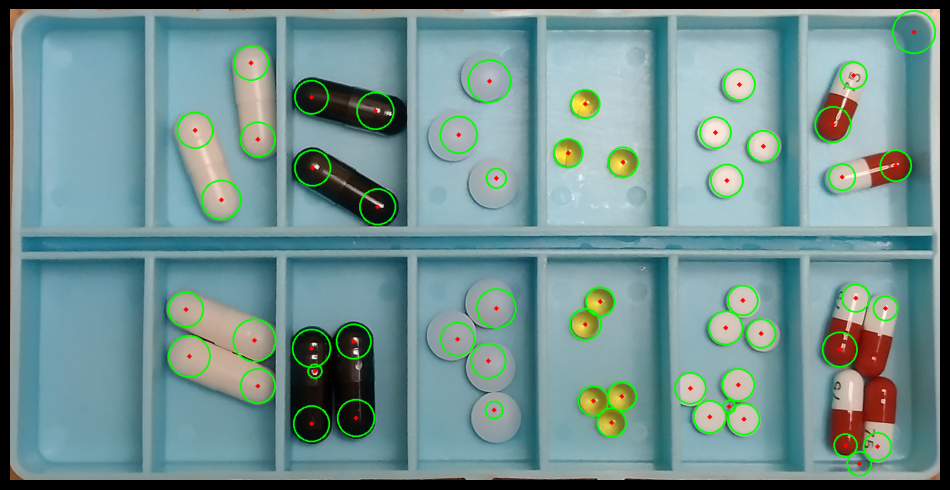

In [25]:
circles = cv2.HoughCircles(
  h_blurred,
  cv2.HOUGH_GRADIENT,
  dp=1,
  minDist=30,
  param1=30,
  param2=15,
  minRadius=10,
  maxRadius=40
)

circles = np.uint16(np.around(circles))

calib_circles = calib_cropped.copy()
for i in circles[0,:]:
  cv2.circle(calib_circles,(i[0],i[1]),i[2],(0,255,0),2)
  cv2.circle(calib_circles,(i[0],i[1]),2,(0,0,255),3)
 
plt.figure(figsize=(12,8))
plt.imshow(calib_circles[..., ::-1])
plt.axis('off')
plt.show()

In [ ]:
# Definicja klas tabletek
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

# Definicja kolormap dla wizualizacji (w formacie BGR)
COLORMAP = {
    PillType.PROBIO: (255, 255, 255),     # Białe
    PillType.CARBON: (0, 0, 0),           # Czarne
    PillType.KETO: (255, 0, 0),           # Niebieskie (BGR)
    PillType.ESPU: (0, 255, 255),         # Żółte (BGR)
    PillType.BIOX: (255, 0, 255),         # Małe białe (BGR)
    PillType.LINE: (0, 0, 255),           # Czerwone (BGR)
}

@dataclass
class Pill:
    type: PillType
    is_capsule: bool = False
    center: Tuple[int, int]
    radius: int
    length: float = None
    width: float = None 
    angle: float = None 

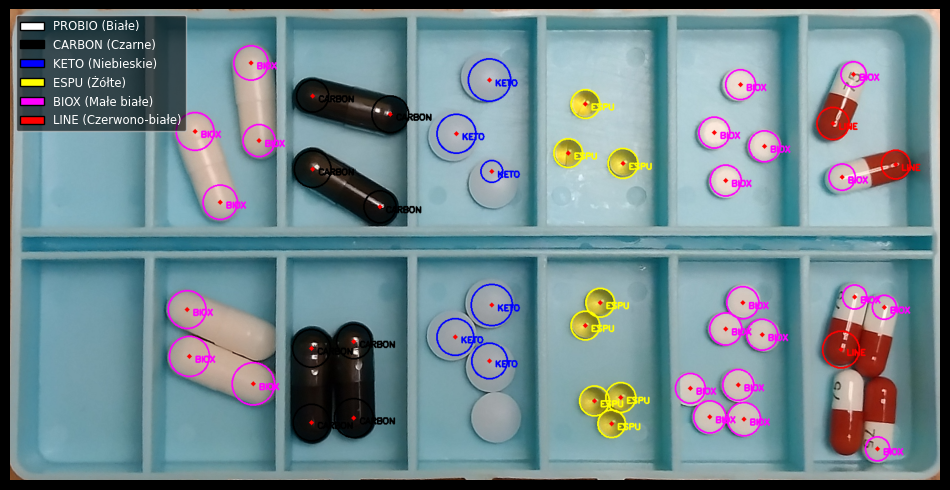

In [ ]:
def detect_objects(image: np.ndarray, debug: bool = False) -> List[Pill]:
    detected_pills = []
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(rgb)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_channel, s_channel, v_channel = cv2.split(hsv)

    h_blurred = cv2.GaussianBlur(h_channel, (5, 5), 0)
    _, h_binary = cv2.threshold(h_blurred, 100, 255, cv2.THRESH_BINARY_INV)
    h_channel[h_binary == 0] = 0

    v_blurred = cv2.GaussianBlur(v_channel, (5, 5), 0)
    _, v_binary = cv2.threshold(v_blurred, 50, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)
    h_channel[v_binary_eroded == 0] = 0
    
    h_blurred = cv2.GaussianBlur(h_channel, (7,7), 0)
    
    circles = cv2.HoughCircles(
        h_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=30,
        param1=30,
        param2=15,
        minRadius=18,
        maxRadius=40
    )
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            
            # Pobierz kolor piksela w centrum okręgu
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.circle(mask, center, radius//2, 255, -1)
            
            # Get mean HSV values in the masked area
            mean_hsv = cv2.mean(hsv, mask=mask)
            h, s, v = mean_hsv[:3]
            
            if v < 80:  # Czarne kapsułki
                pill_type = PillType.CARBON
            
            elif 90 <= h <= 130:  # Niebieskie tabletki
                pill_type = PillType.KETO

            elif 20 <= h <= 30 and s > 100:  # Żółte kapsułki
                pill_type = PillType.ESPU
            
            elif (0 <= h <= 10) or (160 <= h <= 180) and s > 200:  # Czerwono-białe kapsułki
                pill_type = PillType.LINE
            
            elif h < 50 and s < 50:  # Białe tabletki
                pill_type = PillType.BIOX
            
            else:
                print(f'Unknown pill color: H={h}, S={s}, V={v}. At location: {center}')
                continue
            
            detected_pills.append(Pill(pill_type, center, radius))
    
    return detected_pills

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    image_display = image.copy()
    for pill in objects:
        if pill.type in PillType:
            # if pill.type == PillType.CARBON:
            #     print(f'Found a CARBON pill at location: {pill.center}')
            # Rysowanie okręgów
            cv2.circle(image_display, pill.center, pill.radius, COLORMAP[pill.type], 2)
            cv2.circle(image_display, pill.center, 2, (0, 0, 255), 3)
            # Dodawanie etykiety
            cv2.putText(
                image_display, 
                pill.type.name, 
                (pill.center[0]+10, pill.center[1]+10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                COLORMAP[pill.type], 
                2
            )
    
    # Tworzenie legendy (konwersja BGR na RGB)
    legend_elements = [
        Patch(facecolor=np.array(COLORMAP[PillType.PROBIO])[::-1]/255,  edgecolor='k', label='PROBIO (Białe)'),
        Patch(facecolor=np.array(COLORMAP[PillType.CARBON])[::-1]/255,  edgecolor='k', label='CARBON (Czarne)'),
        Patch(facecolor=np.array(COLORMAP[PillType.KETO])[::-1]  /255,  edgecolor='k', label='KETO (Niebieskie)'),
        Patch(facecolor=np.array(COLORMAP[PillType.ESPU])[::-1]  /255,  edgecolor='k', label='ESPU (Żółte)'),
        Patch(facecolor=np.array(COLORMAP[PillType.BIOX])[::-1]  /255,  edgecolor='k', label='BIOX (Małe białe)'),
        Patch(facecolor=np.array(COLORMAP[PillType.LINE])[::-1]  /255,  edgecolor='k', label='LINE (Czerwono-białe)'),
    ]
    
    plt.figure(figsize=(12,8))
    plt.imshow(cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='upper left', fontsize='small', framealpha=0.6)
    plt.show()

circles = detect_objects(calib_cropped, debug=True)
display_objects(calib_cropped, circles)

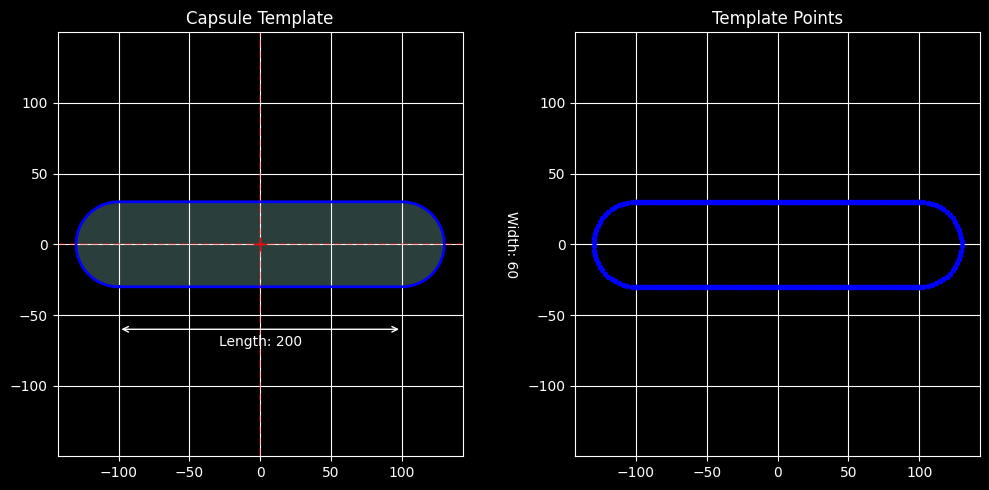

In [33]:
def generate_capsule_points(length: float, width: float, num_points: int = 64) -> np.ndarray:
    points = []
    radius = width / 2
    
    straight_points = 100  # Number of points along straight edges
    
    angles_end = np.linspace(-np.pi/2, np.pi/2, num_points//2)
    angles_transition = np.linspace(-np.pi/4, np.pi/4, num_points//4)  # More points at transition
    
    for i in range(straight_points):
        t = i / (straight_points - 1)
        points.append([t * length - length/2, -radius])
    
    for angle in angles_end:
        x = length/2 + radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append([x, y])
        
    for i in range(straight_points):
        t = i / (straight_points - 1)
        points.append([t * length - length/2, radius])
    
    for angle in angles_end:
        x = -length/2 - radius * np.cos(angle)
        y = -radius * np.sin(angle)
        points.append([x, y])
    
    return np.array(points)

def visualize_capsule_template(length: float, width: float, num_points: int = 32) -> None:
    
    points = generate_capsule_points(length, width, num_points)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(points[:, 0], points[:, 1], 'b-', linewidth=2)
    plt.fill(points[:, 0], points[:, 1], alpha=0.3)
    plt.grid(True)
    plt.axis('equal')
    plt.title('Capsule Template')
    
    plt.plot(0, 0, 'r+', markersize=10)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    
    plt.annotate('', xy=(length/2, -width), xytext=(-length/2, -width),
                arrowprops=dict(arrowstyle='<->'))
    plt.text(0, -width*1.2, f'Length: {length}', ha='center')
    
    plt.annotate('', xy=(length/2 + width, width/2), xytext=(length/2 + width, -width/2),
                arrowprops=dict(arrowstyle='<->'))
    plt.text(length/2 + width*1.2, 0, f'Width: {width}', va='center', rotation=-90)
    
    plt.subplot(122)
    plt.plot(points[:, 0], points[:, 1], 'b.-', linewidth=0)
    plt.grid(True)
    plt.axis('equal')
    plt.title('Template Points')
    
    plt.tight_layout()
    plt.show()
    
    return points

points = visualize_capsule_template(200, 60, 64)

In [34]:
def analyze_capsule_colors(image: np.ndarray, cx: float, cy: float, length: float, width: float, angle: float) -> tuple:
    angle_rad = np.radians(angle)
    
    # Calculate end points
    half_length = length / 2
    dx = half_length * np.cos(angle_rad)
    dy = half_length * np.sin(angle_rad)
    
    # Get coordinates for both ends
    left_x = int(cx - dx)
    left_y = int(cy - dy)
    right_x = int(cx + dx)
    right_y = int(cy + dy)
    
    # Create small circular masks for sampling colors at ends
    radius = int(width)
    sample_radius = int(radius/2)  # Use smaller radius for sampling
    
    # Create masks for both ends
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    left_mask = ((x - left_x)**2 + (y - left_y)**2 <= sample_radius**2)
    right_mask = ((x - right_x)**2 + (y - right_y)**2 <= sample_radius**2)
    center_mask = ((x - cx)**2 + (y - cy)**2 <= sample_radius**2)
    
    # Convert image to HSV if it's not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    else:
        return None, None
    
    # Calculate mean HSV values for both ends
    left_hsv = cv2.mean(hsv, mask=left_mask.astype(np.uint8))[:3]
    right_hsv = cv2.mean(hsv, mask=right_mask.astype(np.uint8))[:3]
    center_hsv = cv2.mean(hsv, mask=center_mask.astype(np.uint8))[:3]
    
    return left_hsv, right_hsv, center_hsv

def classify_pill_color(left_hsv: tuple, right_hsv: tuple, center_hsv: tuple) -> str:
    """
    Classify pill based on HSV values at both ends.
    Returns: 'white', 'black', 'white-red', or 'unknown'
    """
    def is_black(hsv):
        _, _, v = hsv
        return v < 80
    
    def is_white(hsv, h_thresh=40):
        h, s, v = hsv
        return h < h_thresh and v > 100
    
    def is_red(hsv):
        h, s, v = hsv
        return ((0 <= h <= 50) or (150 <= h <= 200)) and s > 100
    
    if is_black(left_hsv) and is_black(right_hsv) and is_black(center_hsv):
        return 'black'
    elif is_white(left_hsv) and is_white(right_hsv) and is_white(center_hsv):
        return 'white'
    elif (is_white(left_hsv, h_thresh=50) and is_red(right_hsv)) or (is_red(left_hsv) and is_white(right_hsv, h_thresh=50)):
        return 'white-red'
    else:
        return 'unknown'

In [35]:
def enhanced_non_max_suppression_capsules(
    capsules: List[Tuple],
    image: np.ndarray,
    angle_thresh: float = 15.0,
) -> List[Tuple]:
    if not capsules:
        return []
    
    # Sort capsules by score
    capsules = sorted(capsules, key=lambda x: x[5], reverse=True)
    kept_capsules = []
    
    # Remove border detections
    border_margin = 20
    height, width = image.shape[:2]
    
    for capsule in capsules:
        cx1, cy1, l1, w1, a1, score = capsule
        
        # Skip border detections
        if (cx1 < border_margin or cx1 > width - border_margin or 
            cy1 < border_margin or cy1 > height - border_margin):
            continue
        
        left_hsv, right_hsv, center_hsv = analyze_capsule_colors(image, cx1, cy1, l1, w1, a1)
        if left_hsv is None or right_hsv is None:
            continue
            
        color_type = classify_pill_color(left_hsv, right_hsv, center_hsv)
        if color_type == 'unknown':
            continue

        aspect_ratio = l1 / w1
        if not (1.5 <= aspect_ratio <= 3.0):  # Typical pill aspect ratio range
            continue
        
        # Non-maximum suppression
        overlaps = False
        for kept_capsule in kept_capsules:
            cx2, cy2, l2, w2, a2, score = kept_capsule
            
            # Distance check
            dist = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
            
            # Angle difference check
            angle_diff = min(abs(a1-a2), 180-abs(a1-a2))
            
            # Dynamic distance threshold based on pill size
            avg_length = (l1 + l2) / 2
            dist_threshold = avg_length * 0.8
            
            if dist < dist_threshold and angle_diff < angle_thresh:
                overlaps = True
                break
        
        if not overlaps:
            kept_capsules.append(capsule)
    
    return kept_capsules

Detected 14 compartments
Processing compartment 1


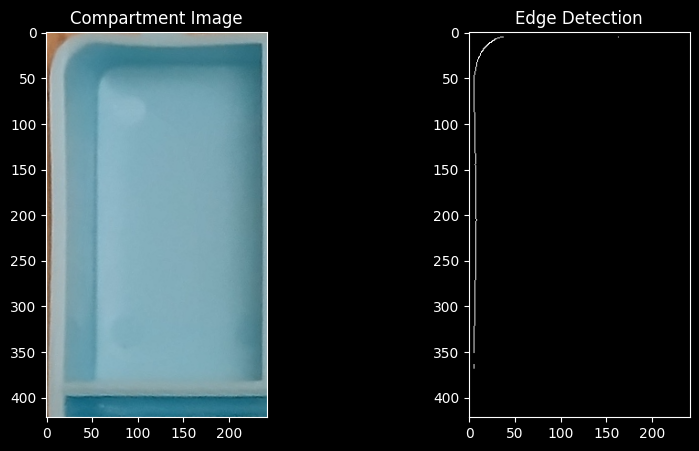

Detecting capsules: 100%|██████████| 324/324 [00:02<00:00, 121.52it/s]


Found 189 capsules before NMS
Found 0 capsules after NMS
Processing compartment 2


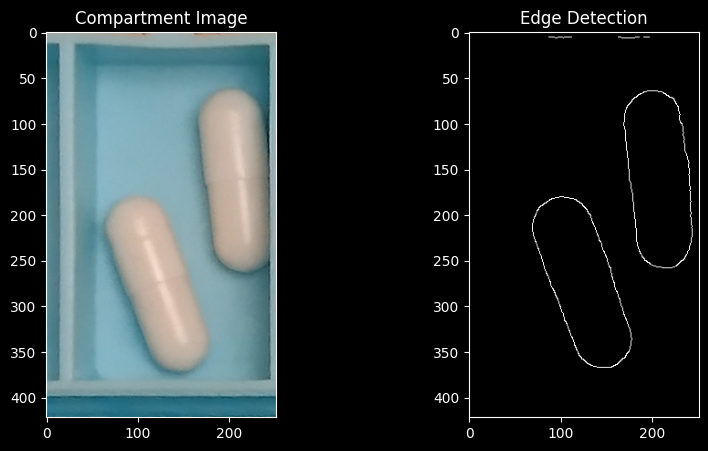

Detecting capsules: 100%|██████████| 324/324 [00:06<00:00, 48.46it/s]


Found 74 capsules before NMS
Found 2 capsules after NMS
Processing compartment 3


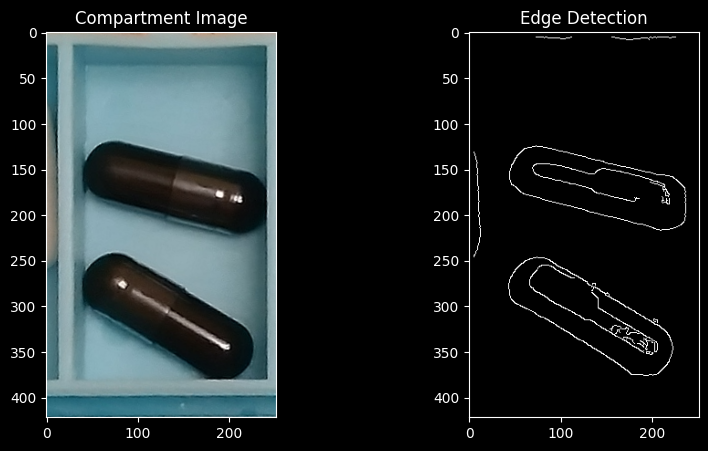

Detecting capsules: 100%|██████████| 324/324 [00:12<00:00, 25.35it/s]


Found 54 capsules before NMS
Found 2 capsules after NMS
Processing compartment 4


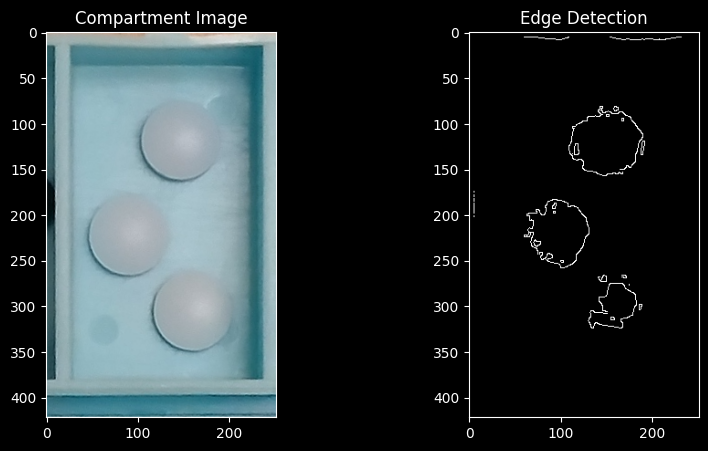

Detecting capsules: 100%|██████████| 324/324 [00:07<00:00, 41.39it/s]


Found 51 capsules before NMS
Found 0 capsules after NMS
Processing compartment 5


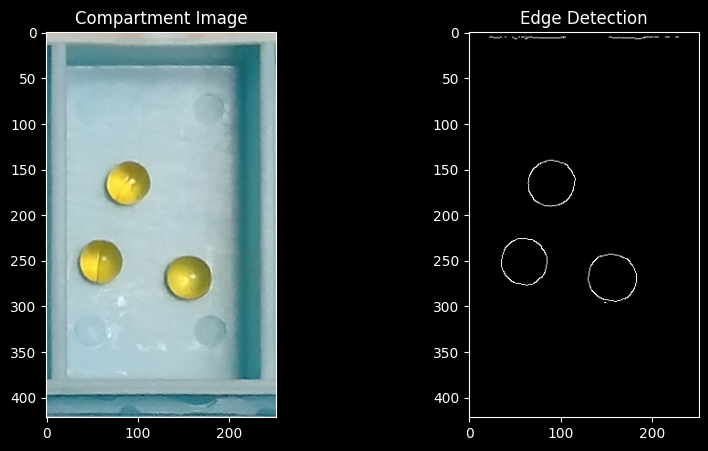

Detecting capsules: 100%|██████████| 324/324 [00:04<00:00, 72.51it/s]


Found 15 capsules before NMS
Found 0 capsules after NMS
Processing compartment 6


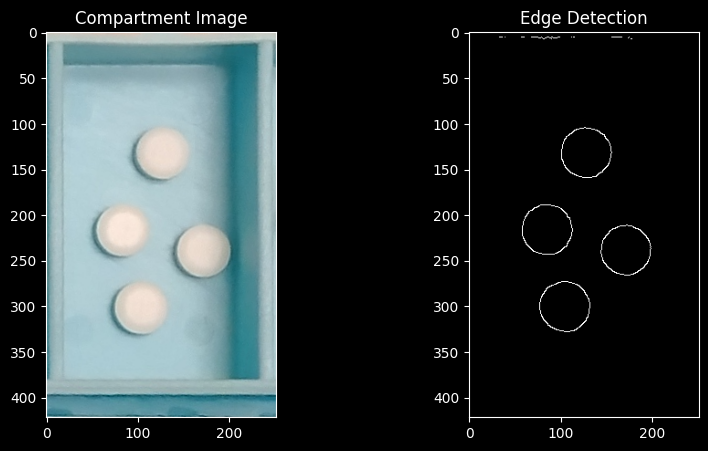

Detecting capsules: 100%|██████████| 324/324 [00:05<00:00, 60.96it/s]


Found 60 capsules before NMS
Found 0 capsules after NMS
Processing compartment 7


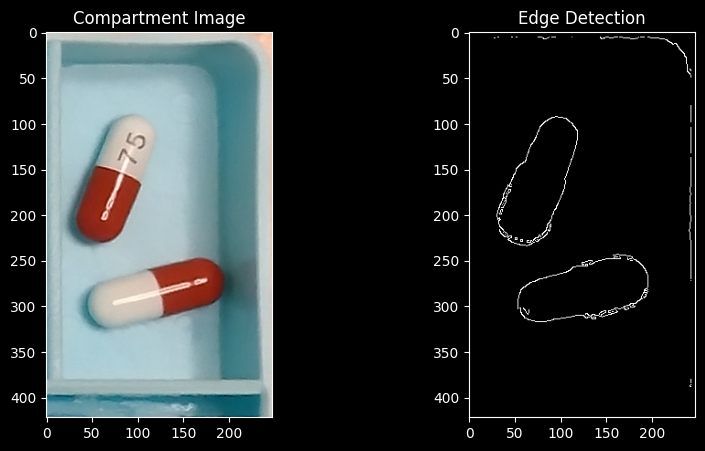

Detecting capsules: 100%|██████████| 324/324 [00:08<00:00, 36.94it/s]


Found 46 capsules before NMS
Found 1 capsules after NMS
Processing compartment 8


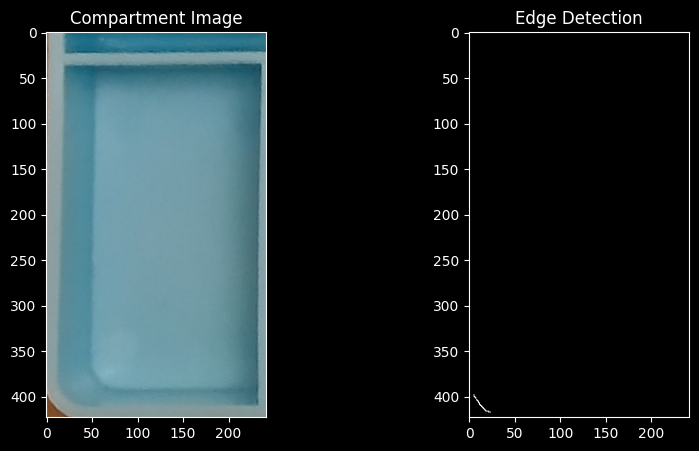

Detecting capsules: 100%|██████████| 324/324 [00:00<00:00, 494.38it/s]


Found 132 capsules before NMS
Found 0 capsules after NMS
Processing compartment 9


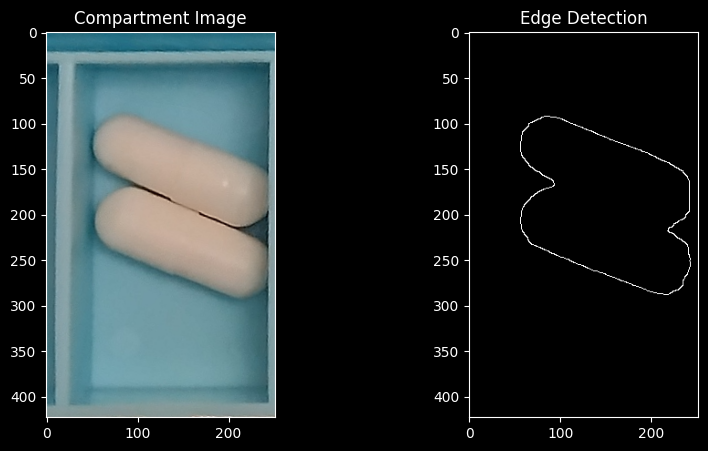

Detecting capsules: 100%|██████████| 324/324 [00:04<00:00, 64.96it/s]


Found 49 capsules before NMS
Found 2 capsules after NMS
Processing compartment 10


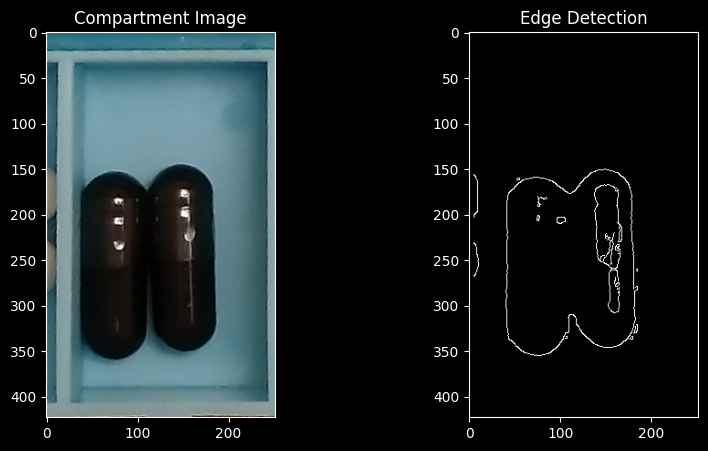

Detecting capsules: 100%|██████████| 324/324 [00:09<00:00, 35.82it/s]


Found 223 capsules before NMS
Found 2 capsules after NMS
Processing compartment 11


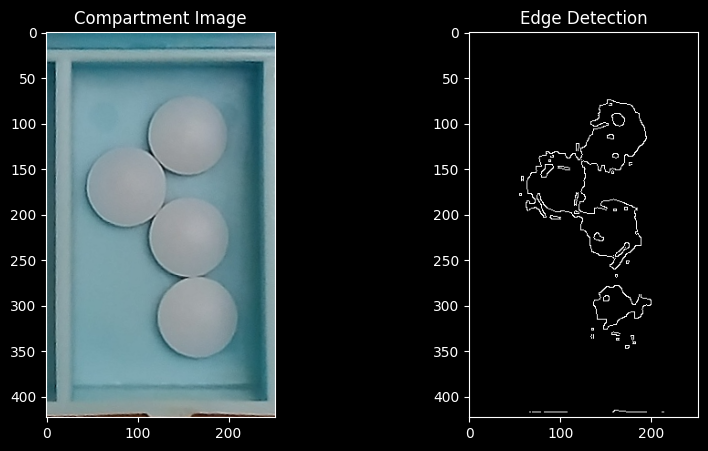

Detecting capsules: 100%|██████████| 324/324 [00:11<00:00, 28.78it/s]


Found 63 capsules before NMS
Found 0 capsules after NMS
Processing compartment 12


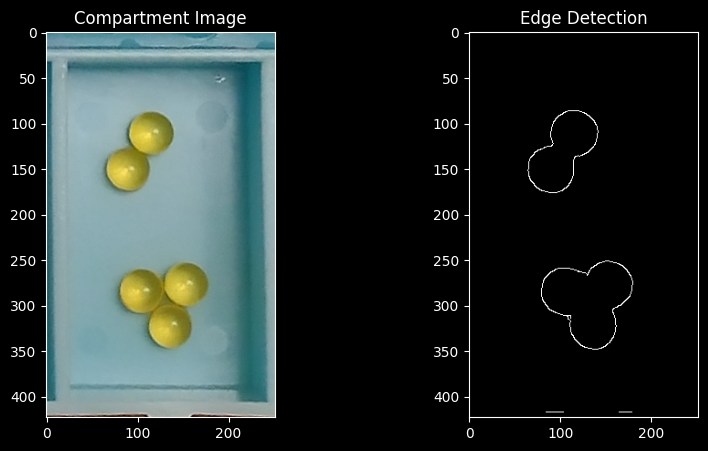

Detecting capsules: 100%|██████████| 324/324 [00:04<00:00, 70.11it/s]


Found 5 capsules before NMS
Found 0 capsules after NMS
Processing compartment 13


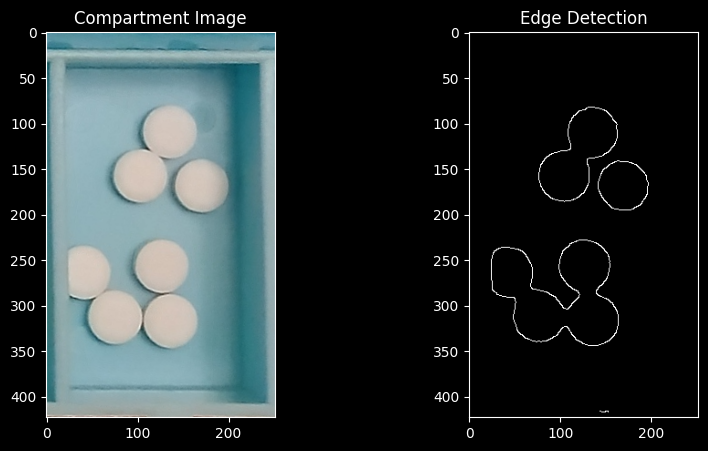

Detecting capsules: 100%|██████████| 324/324 [00:07<00:00, 43.31it/s]


Found 98 capsules before NMS
Found 0 capsules after NMS
Processing compartment 14


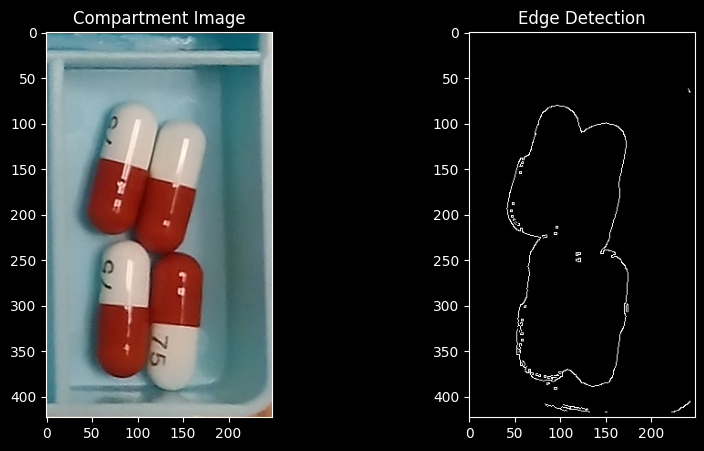

Detecting capsules: 100%|██████████| 324/324 [00:08<00:00, 39.15it/s]


Found 183 capsules before NMS
Found 2 capsules after NMS


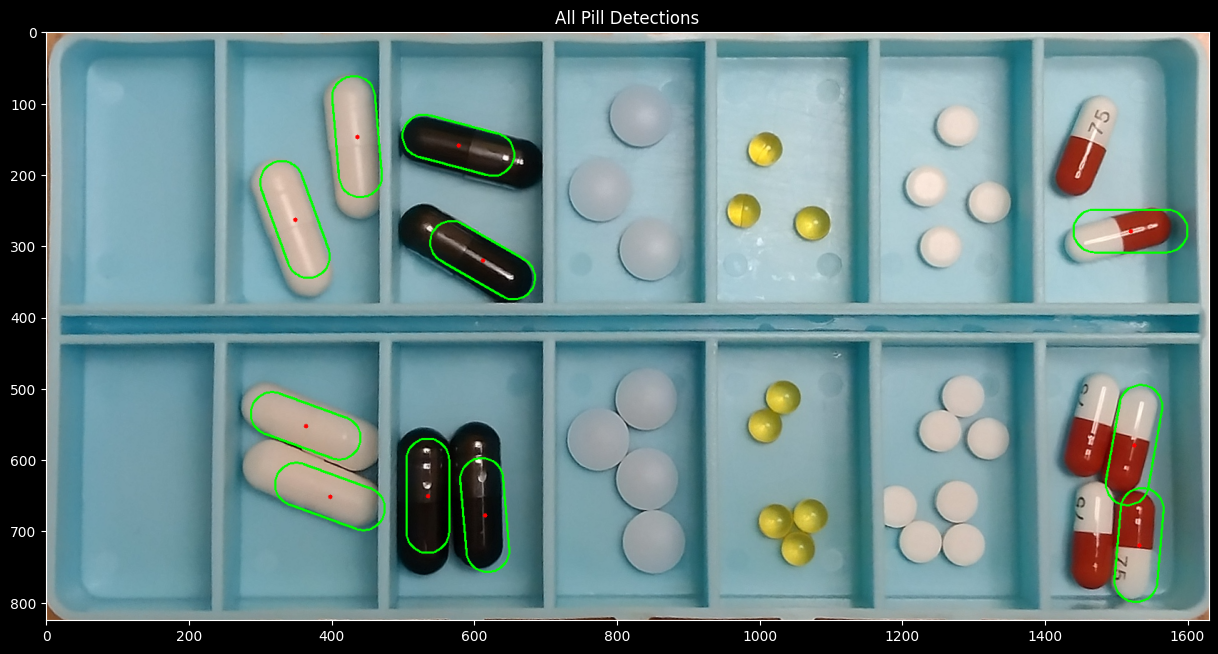

In [36]:
def detect_capsules(compartment_image, edges, debug=False):
    
    angles = np.arange(0, 180, 5)
    lengths = np.arange(100, 130, 10)
    # lengths = np.append(lengths, 0)       # Analiza okręgów
    widths = np.arange(60, 81, 10)
    
    y_coords, x_coords = np.nonzero(edges)
    edge_points = np.column_stack((x_coords, y_coords))
    
    if len(edge_points) == 0:
        print("No edge points detected!")
        return []
    
    max_votes = 0
    capsules = []
    
    total_iterations = len(angles) * len(lengths) * len(widths)
    with tqdm(total=total_iterations, desc="Detecting capsules") as pbar:
        for angle in angles:
            angle_rad = np.radians(angle)
            rot_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                 [np.sin(angle_rad), np.cos(angle_rad)]])
            
            for length in lengths:
                for width in widths:

                    template_points = generate_capsule_points(length, width)
                    rotated_template = np.dot(template_points, rot_matrix.T)
                    
                    votes = np.zeros(compartment_image.shape[:2], dtype=np.float32)
                    
                    for edge_point in edge_points:
                        translated = rotated_template + edge_point
                        
                        valid_idx = (
                            (translated[:, 0] >= 0) & 
                            (translated[:, 0] < compartment_image.shape[1]) & 
                            (translated[:, 1] >= 0) & 
                            (translated[:, 1] < compartment_image.shape[0])
                        )
                        
                        if np.any(valid_idx):
                            points = translated[valid_idx].astype(np.int32)
                            votes[points[:, 1], points[:, 0]] += 1
                    
                    vote_threshold = np.max(votes) * 0.7
                    local_max = peak_local_max(votes, min_distance=20, threshold_abs=vote_threshold, exclude_border=True)
                    
                    for y, x in local_max:
                        score = votes[y, x]
                        if score > max_votes * 0.8:  # Only keep strong matches
                            capsules.append((x, y, length, width, angle, score))
                            max_votes = max(max_votes, score)
                    
                    pbar.update(1)
    
    print(f"Found {len(capsules)} capsules before NMS")

    final_capsules = enhanced_non_max_suppression_capsules(
        capsules,
        compartment_image,
        angle_thresh=140.0,
    )

    print(f"Found {len(final_capsules)} capsules after NMS")
    
    return final_capsules


def detect_pills_in_compartment(compartment_image: np.ndarray, debug: bool = False) -> List[Tuple]:

    hsv = cv2.cvtColor(compartment_image, cv2.COLOR_BGR2HSV)

    h_channel, s_channel, v_channel = cv2.split(hsv)
    h_blurred = cv2.GaussianBlur(h_channel, (5, 5), 0)
    _, h_binary = cv2.threshold(h_blurred, 100, 255, cv2.THRESH_BINARY_INV)
    h_channel[h_binary == 0] = 0

    v_blurred = cv2.GaussianBlur(v_channel, (5, 5), 0)
    _, v_binary = cv2.threshold(v_blurred, 50, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)
    h_channel[v_binary_eroded == 0] = 0
    
    h_blurred = cv2.GaussianBlur(h_channel, (3, 3), 0)
    edges = cv2.Canny(h_blurred, 5, 70)
    
    border_margin = 5
    edges[:border_margin, :] = 0
    edges[-border_margin:, :] = 0
    edges[:, :border_margin] = 0
    edges[:, -border_margin:] = 0

    if debug:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(compartment_image, cv2.COLOR_BGR2RGB))
        plt.title('Compartment Image')
        plt.subplot(122)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.show()
    
    final_capsules = detect_capsules(compartment_image, edges, debug=debug)

    return final_capsules
        

def detect_pills_in_pillbox(image: np.ndarray, debug: bool = False) -> List[Tuple]:

    cells = get_cells_of_pillbox(image)
    print(f"Detected {len(cells)} compartments")
    
    all_detections = []
    cell_height = image.shape[0] // 2
    cell_width = image.shape[1] // 7
    
    for i, cell in enumerate(cells):
        # if i != 6 and i != 13:
        #     continue
        print(f"Processing compartment {i+1}")
        row = i // 7
        col = i % 7
        
        compartment_detections = detect_pills_in_compartment(cell, debug=debug)
        
        for detection in compartment_detections:
            cx, cy, length, width, angle, score = detection
            adjusted_x = cx + (col * cell_width)
            adjusted_y = cy + (row * cell_height)

            adjusted_detection = (adjusted_x, adjusted_y, length, width, angle, score)
            all_detections.append(adjusted_detection)
    
    if debug:
        debug_img = image.copy()
        for cx, cy, length, width, angle, _ in all_detections:
            template_points = generate_capsule_points(length, width)
            angle_rad = np.radians(angle)
            rot_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                 [np.sin(angle_rad), np.cos(angle_rad)]])
            points = np.dot(template_points, rot_matrix.T) + [cx, cy]
            cv2.polylines(debug_img, [points.astype(np.int32)], True, (0, 255, 0), 2)
            cv2.circle(debug_img, (int(cx), int(cy)), 3, (0, 0, 255), -1)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
        plt.title('All Pill Detections')
        plt.show()
    
    return all_detections

detections = detect_pills_in_pillbox(calib_cropped, debug=True)